<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png" width="400"></p>

# Домашнее задание. Обучение языковой модели с помощью LSTM (10 баллов)

Э
В этом задании Вам предстоит обучить языковую модель с помощью рекуррентной нейронной сети. В отличие от семинарского занятия, Вам необходимо будет работать с отдельными словами, а не буквами.


Установим модуль ```datasets```, чтобы нам проще было работать с данными.

Импорт необходимых библиотек

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List

import seaborn
seaborn.set(palette='summer')

In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mserg\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных

Воспользуемся датасетом imdb. В нем хранятся отзывы о фильмах с сайта imdb. Загрузим данные с помощью функции ```load_dataset```

In [4]:
# Загрузим датасет
dataset = load_dataset('imdb')

### Препроцессинг данных и создание словаря (1 балл)

Далее вам необходмо самостоятельно произвести препроцессинг данных и получить словарь или же просто ```set``` строк. Что необходимо сделать:

1. Разделить отдельные тренировочные примеры на отдельные предложения с помощью функции ```sent_tokenize``` из бибилиотеки ```nltk```. Каждое отдельное предложение будет одним тренировочным примером.
2. Оставить только те предложения, в которых меньше ```word_threshold``` слов.
3. Посчитать частоту вхождения каждого слова в оставшихся предложениях. Для деления предлоения на отдельные слова удобно использовать функцию ```word_tokenize```.
4. Создать объект ```vocab``` класса ```set```, положить в него служебные токены '\<unk\>', '\<bos\>', '\<eos\>', '\<pad\>' и vocab_size самых частовстречающихся слов.   

In [19]:
def preprocess_text(text):
    # Удалить табуляции, лишние пробелы и символы новой строки
    text = " ".join(text.split())
    text = text.replace('<', '').replace('>', '').replace('br', '').replace('/', '')
    return text

In [20]:
sentences = []
word_threshold = 32

# Получить отдельные предложения и поместить их в sentences
for sentence in tqdm(dataset['train']['text']):
    sentences.extend(
        [x.lower() for x in sent_tokenize(preprocess_text(sentence), language='english') if len(word_tokenize(x)) < word_threshold]
        )

  0%|          | 0/25000 [00:00<?, ?it/s]

In [21]:
print("Всего предложений:", len(sentences))

Всего предложений: 254303


Посчитаем для каждого слова его встречаемость.

In [22]:
words = Counter()

for sentence in tqdm(sentences):
    for word in word_tokenize(sentence):
        words[word] += 1

  0%|          | 0/254303 [00:00<?, ?it/s]

In [92]:
len(words)

75908

Добавим в словарь ```vocab_size``` самых встречающихся слов.

In [25]:
vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
vocab_size = 40000
size = 0

for word, cnt in words.items():
    if size >= 40000:
        break
    vocab.add(word)
    size += 1

In [26]:
assert '<unk>' in vocab
assert '<bos>' in vocab
assert '<eos>' in vocab
assert '<pad>' in vocab
assert len(vocab) == vocab_size + 4

In [27]:
print("Всего слов в словаре:", len(vocab))

Всего слов в словаре: 40004


### Подготовка датасета (1 балл)

Далее, как и в семинарском занятии, подготовим датасеты и даталоадеры.

В классе ```WordDataset``` вам необходимо реализовать метод ```__getitem__```, который будет возвращать сэмпл данных по входному idx, то есть список целых чисел (индексов слов).

Внутри этого метода необходимо добавить служебные токены начала и конца последовательности, а также токенизировать соответствующее предложение с помощью ```word_tokenize``` и сопоставить ему индексы из ```word2ind```.

In [28]:
word2ind = {word: i for i, word in enumerate(vocab)}
ind2word = {i: word for word, i in word2ind.items()}

In [29]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        tokenized_sentence = [self.bos_id]
        # Допишите код здесь
        tokenized_sentence += [word2ind.get(word, self.unk_id) for word in word_tokenize(self.data[idx])] 
        tokenized_sentence += [self.eos_id]

        return tokenized_sentence

    def __len__(self) -> int:
        return len(self.data)

In [30]:
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>']) -> torch.Tensor:
    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)

    new_batch = []
    for sequence in input_batch:
        for _ in range(max_seq_len - len(sequence)):
            sequence.append(pad_id)
        new_batch.append(sequence)

    sequences = torch.LongTensor(new_batch).to(device)

    new_batch = {
        'input_ids': sequences[:,:-1],
        'target_ids': sequences[:,1:]
    }

    return new_batch

In [33]:
train_sentences, eval_sentences = train_test_split(sentences, test_size=0.2)
eval_sentences, test_sentences = train_test_split(eval_sentences, test_size=0.5)

train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(eval_sentences)
test_dataset = WordDataset(test_sentences)

batch_size = 128

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

test_dataloader = DataLoader(
    test_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

In [34]:
for x in test_dataloader:
  print([ind2word[w.item()] for w in x['input_ids'][50]])
  break

['<bos>', 'the', 'film', 'ends', 'on', 'a', 'sour', 'note', 'as', 'the', 'embarrassed', 'family', 'moves', 'out', 'of', 'their', 'fancy', 'digs', 'and', 'take', 'to', 'riding', 'around', 'beverly', 'hills', 'in', 'their', 'car', '.', '<eos>', '<pad>', '<pad>']


## Обучение и архитектура модели

Вам необходимо на практике проверить, что влияет на качество языковых моделей. В этом задании нужно провести серию экспериментов с различными вариантами языковых моделей и сравнить различия в конечной перплексии на тестовом множестве.

Возмоэные идеи для экспериментов:

* Различные RNN-блоки, например, LSTM или GRU. Также можно добавить сразу несколько RNN блоков друг над другом с помощью аргумента num_layers. Вам поможет официальная документация [здесь](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)
* Различные размеры скрытого состояния. Различное количество линейных слоев после RNN-блока. Различные функции активации.
* Добавление нормализаций в виде Dropout, BatchNorm или LayerNorm
* Различные аргументы для оптимизации, например, подбор оптимального learning rate или тип алгоритма оптимизации SGD, Adam, RMSProp и другие
* Любые другие идеи и подходы

После проведения экспериментов необходимо составить таблицу результатов, в которой описан каждый эксперимент и посчитана перплексия на тестовом множестве.

Учтите, что эксперименты, которые различаются, например, только размером скрытого состояния или количеством линейных слоев считаются, как один эксперимент.

Успехов!

### Функция evaluate (1 балл)

Заполните функцию ```evaluate```

In [35]:
def evaluate(model, criterion, dataloader) -> float:
    model.eval()
    perplexity = []
    with torch.no_grad():
        for batch in dataloader:
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1) # Посчитайте логиты предсказаний следующих слов
            loss = criterion(logits, batch['target_ids'].flatten())
            perplexity.append(torch.exp(loss).item())

    perplexity = sum(perplexity) / len(perplexity)

    return perplexity

### Train loop (1 балл)

Напишите функцию для обучения модели.

In [38]:
def train_model(num_epoch, model, optimizer, criterion):
    losses = []
    perplexities_test = []
    perplexities_eval = []

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for batch in tqdm(train_dataloader, desc=f'Training epoch {epoch}:'):
            optimizer.zero_grad()
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(
                logits, batch['target_ids'].flatten())
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
        
        losses.append(sum(epoch_losses) / len(epoch_losses))
        perplexities_test.append(evaluate(model, criterion, test_dataloader))
        perplexities_eval.append(evaluate(model, criterion, eval_dataloader))
    return losses, perplexities_test, perplexities_eval

Считаем перплексию на тесте и валидации

### Первый эксперимент (2 балла)

Определите архитектуру модели и обучите её.

In [42]:
class FirstLanguageModel(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int):
        super().__init__()
        # Опишите свою нейронную сеть здесь
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, num_layers=4, batch_first=True) # увеличил количество слоёв
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout_1 = nn.Dropout(p=0.2) # увеличил dropout

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        # А тут опишите forward pass модели
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
        output = self.dropout_1(self.linear(self.non_lin(output)))  # [batch_size, seq_len, hidden_dim]
        projection = self.projection(self.non_lin(output))  # [batch_size, seq_len, vocab_size]

        return projection

Для начала попробуем такую архитектуру

In [43]:
model = FirstLanguageModel(hidden_dim=512, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.001)

In [44]:
experiment_params = {}
experiment_losses = {}
experiment_perplexities_test = {}
experiment_perplexities_eval = {}

In [ ]:
experiment_params[1] = ['lr = 0.01', 'weight_decay = 0.01', 'num_epoch = 15', '4 layers GRU', '1 dropout']
experiment_losses[1], experiment_perplexities_test[1], experiment_perplexities_eval[1] = train_model(15, model, optimizer, criterion)

Training epoch 0::   0%|          | 0/1590 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/1590 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/1590 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/1590 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/1590 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/1590 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/1590 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/1590 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/1590 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/1590 [00:00<?, ?it/s]

Training epoch 10::   0%|          | 0/1590 [00:00<?, ?it/s]

Training epoch 11::   0%|          | 0/1590 [00:00<?, ?it/s]

Training epoch 12::   0%|          | 0/1590 [00:00<?, ?it/s]

Training epoch 13::   0%|          | 0/1590 [00:00<?, ?it/s]

Training epoch 14::   0%|          | 0/1590 [00:00<?, ?it/s]

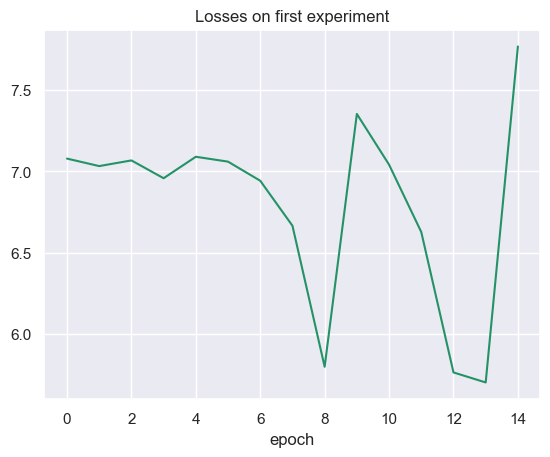

In [46]:
plt.plot(np.arange(len(experiment_losses[1])), experiment_losses[1])
plt.title('Losses on first experiment')
plt.xlabel("epoch")
plt.show()

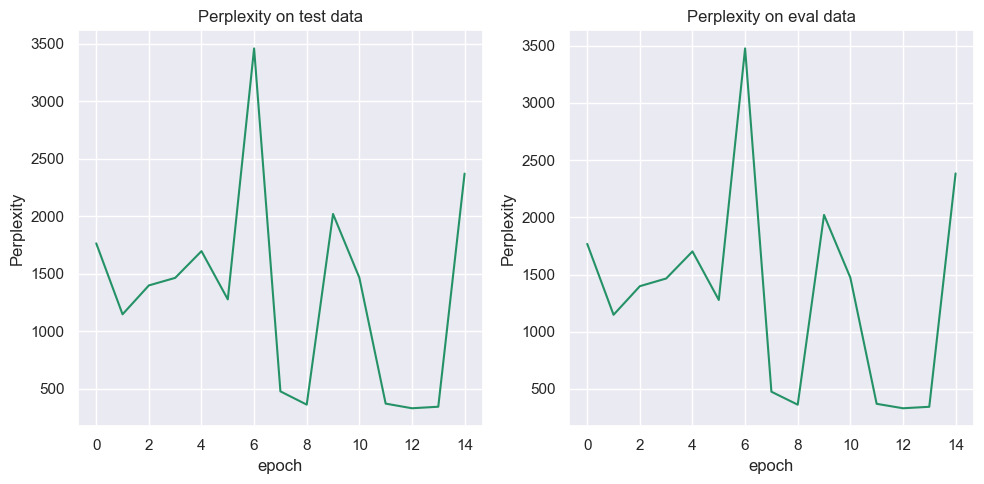

In [57]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(np.arange(len(experiment_perplexities_test[1])), experiment_perplexities_test[1])
ax2.plot(np.arange(len(experiment_perplexities_eval[1])), experiment_perplexities_eval[1])

ax1.set_title('Perplexity on test data')
ax1.set_xlabel("epoch")
ax1.set_ylabel("Perplexity")

ax2.set_title('Perplexity on eval data')
ax2.set_xlabel("epoch")
ax2.set_ylabel("Perplexity")

plt.tight_layout()
plt.show()

In [58]:
def generate_sequence(model, starting_seq: str, max_seq_len: int = 128) -> str:
    device = 'cpu'
    model = model.to(device)
    input_ids = [word2ind['<bos>']] + [
        word2ind.get(word, word2ind['<unk>']) for word in word_tokenize(starting_seq)]
    input_ids = torch.LongTensor(input_ids).to(device)
    
    model.eval()
    with torch.no_grad():
        for i in range(max_seq_len):
            next_word_distribution = model(input_ids)[-1]
            next_word = next_word_distribution.squeeze().argmax()
            input_ids = torch.cat([input_ids, next_word.unsqueeze(0)])

            if next_word.item() == word2ind['<eos>']:
                break
    
    words = ' '.join([ind2word[idx.item()] for idx in input_ids])

    return words

In [63]:
generate_sequence(model, starting_seq='i think this')

'<bos> i think this dregs dregs dregs dregs dregs dregs <eos>'

Что-то неладное...

In [66]:
torch.cuda.empty_cache()

### Второй эксперимент (2 балла)

Попробуйте что-то поменять в модели или в пайплайне обучения, идеи для экспериментов можно подсмотреть выше.

In [68]:
class SecondLanguageModel(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int):
        super().__init__()
        # Опишите свою нейронную сеть здесь
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, num_layers=3, batch_first=True) # уменьшил количество слоёв
        self.layer_norm = nn.LayerNorm(hidden_dim)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout_1 = nn.Dropout(p=0.3) # увеличил dropout
        self.dropout_2 = nn.Dropout(p=0.1) # добавил ещё один dropout

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        # А тут опишите forward pass модели
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        embeddings = self.layer_norm(embeddings) # нормализация после эмбеддинга
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
        output = self.layer_norm(output) # нормализация после GRU
        output = self.dropout_1(self.linear(self.non_lin(output)))  # [batch_size, seq_len, hidden_dim]
        output = self.linear(self.non_lin(output))
        output = self.dropout_2(self.linear(self.non_lin(output)))  # [batch_size, seq_len, hidden_dim]
        projection = self.projection(self.non_lin(output))  # [batch_size, seq_len, vocab_size]

        return projection

In [70]:
model = SecondLanguageModel(hidden_dim=512, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

In [71]:
experiment_params[2] = ['lr = 0.001', 'weight_decay = 0.0001', 'num_epoch = 30', '3 layers GRU', '2 dropout', '2 layer norms']
experiment_losses[2], experiment_perplexities_test[2], experiment_perplexities_eval[2] = train_model(30, model, optimizer, criterion)

Training epoch 0::   0%|          | 0/1590 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/1590 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/1590 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/1590 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/1590 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/1590 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/1590 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/1590 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/1590 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/1590 [00:00<?, ?it/s]

Training epoch 10::   0%|          | 0/1590 [00:00<?, ?it/s]

Training epoch 11::   0%|          | 0/1590 [00:00<?, ?it/s]

Training epoch 12::   0%|          | 0/1590 [00:00<?, ?it/s]

Training epoch 13::   0%|          | 0/1590 [00:00<?, ?it/s]

Training epoch 14::   0%|          | 0/1590 [00:00<?, ?it/s]

Training epoch 15::   0%|          | 0/1590 [00:00<?, ?it/s]

Training epoch 16::   0%|          | 0/1590 [00:00<?, ?it/s]

Training epoch 17::   0%|          | 0/1590 [00:00<?, ?it/s]

Training epoch 18::   0%|          | 0/1590 [00:00<?, ?it/s]

Training epoch 19::   0%|          | 0/1590 [00:00<?, ?it/s]

Training epoch 20::   0%|          | 0/1590 [00:00<?, ?it/s]

Training epoch 21::   0%|          | 0/1590 [00:00<?, ?it/s]

Training epoch 22::   0%|          | 0/1590 [00:00<?, ?it/s]

Training epoch 23::   0%|          | 0/1590 [00:00<?, ?it/s]

Training epoch 24::   0%|          | 0/1590 [00:00<?, ?it/s]

Training epoch 25::   0%|          | 0/1590 [00:00<?, ?it/s]

Training epoch 26::   0%|          | 0/1590 [00:00<?, ?it/s]

Training epoch 27::   0%|          | 0/1590 [00:00<?, ?it/s]

Training epoch 28::   0%|          | 0/1590 [00:00<?, ?it/s]

Training epoch 29::   0%|          | 0/1590 [00:00<?, ?it/s]

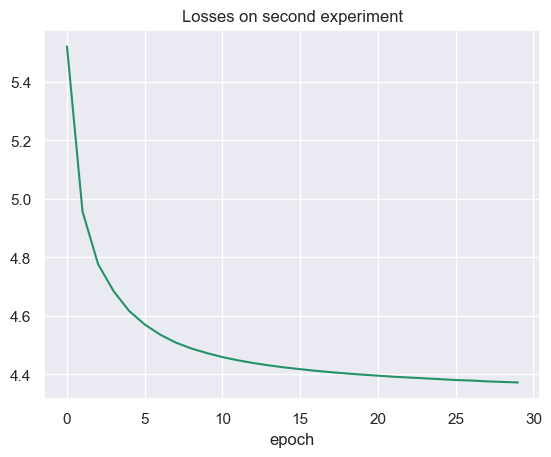

In [90]:
plt.plot(np.arange(len(experiment_losses[2])), experiment_losses[2])
plt.title('Losses on second experiment')
plt.xlabel("epoch")
plt.show()

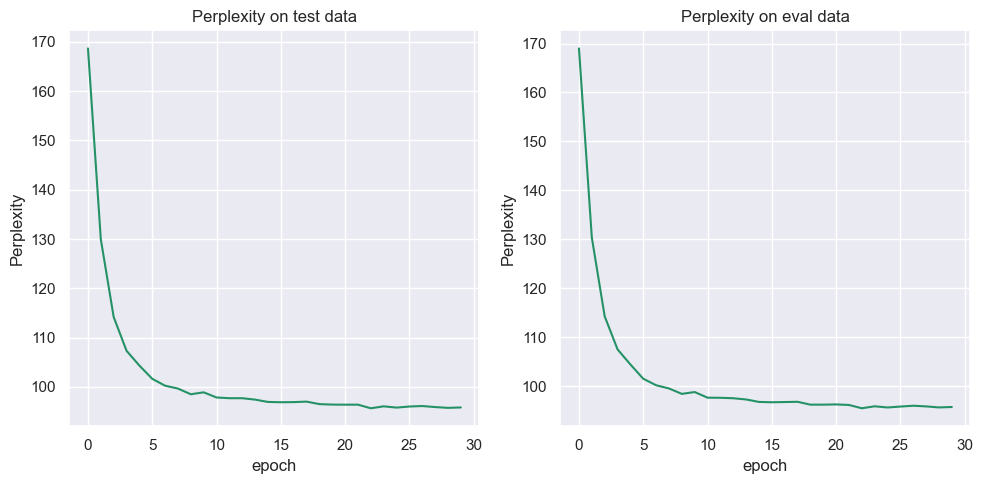

In [74]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(np.arange(len(experiment_perplexities_test[2])), experiment_perplexities_test[2])
ax2.plot(np.arange(len(experiment_perplexities_eval[2])), experiment_perplexities_eval[2])

ax1.set_title('Perplexity on test data')
ax1.set_xlabel("epoch")
ax1.set_ylabel("Perplexity")

ax2.set_title('Perplexity on eval data')
ax2.set_xlabel("epoch")
ax2.set_ylabel("Perplexity")

plt.tight_layout()
plt.show()

In [81]:
generate_sequence(model, starting_seq='he is a bad actor because')

"<bos> he is a bad actor because he 's not a good actor . <eos>"

In [83]:
generate_sequence(model, starting_seq='i dont like this film because')

"<bos> i dont like this film because i 'm sure it was a bit of a comedy . <eos>"

Выглядит очень хорошо. Попробуем во все тяжкие увеличить словарь, сеть и количество эпох

In [91]:
torch.cuda.empty_cache()

In [93]:
vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
vocab_size = 75000
size = 0

for word, cnt in words.items():
    if size >= vocab_size:
        break
    vocab.add(word)
    size += 1

In [94]:
print("Всего слов в словаре:", len(vocab))

Всего слов в словаре: 75004


In [95]:
word2ind = {word: i for i, word in enumerate(vocab)}
ind2word = {i: word for word, i in word2ind.items()}

In [96]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        tokenized_sentence = [self.bos_id]
        # Допишите код здесь
        tokenized_sentence += [word2ind.get(word, self.unk_id) for word in word_tokenize(self.data[idx])] 
        tokenized_sentence += [self.eos_id]

        return tokenized_sentence

    def __len__(self) -> int:
        return len(self.data)

In [97]:
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>']) -> torch.Tensor:
    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)

    new_batch = []
    for sequence in input_batch:
        for _ in range(max_seq_len - len(sequence)):
            sequence.append(pad_id)
        new_batch.append(sequence)

    sequences = torch.LongTensor(new_batch).to(device)

    new_batch = {
        'input_ids': sequences[:,:-1],
        'target_ids': sequences[:,1:]
    }

    return new_batch

In [98]:
train_sentences, eval_sentences = train_test_split(sentences, test_size=0.2)
eval_sentences, test_sentences = train_test_split(eval_sentences, test_size=0.5)

train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(eval_sentences)
test_dataset = WordDataset(test_sentences)

batch_size = 128

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

test_dataloader = DataLoader(
    test_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

In [99]:
class ThirdLanguageModel(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int):
        super().__init__()
        # Опишите свою нейронную сеть здесь
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, num_layers=5, batch_first=True) # уменьшил количество слоёв
        self.layer_norm = nn.LayerNorm(hidden_dim)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout_1 = nn.Dropout(p=0.3) # увеличил dropout
        self.dropout_2 = nn.Dropout(p=0.2) # добавил ещё один dropout
        self.dropout_3 = nn.Dropout(p=0.1) # добавил ещё один dropout

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        # А тут опишите forward pass модели
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        embeddings = self.layer_norm(embeddings) # нормализация после эмбеддинга
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
        output = self.layer_norm(output) # нормализация после GRU
        output = self.dropout_1(self.linear(self.non_lin(output)))  # [batch_size, seq_len, hidden_dim]
        output = self.linear(self.non_lin(output))
        output = self.dropout_2(self.linear(self.non_lin(output)))  # [batch_size, seq_len, hidden_dim]
        output = self.linear(self.non_lin(output))
        output = self.layer_norm(output)
        output = self.dropout_3(self.linear(self.non_lin(output)))  # [batch_size, seq_len, hidden_dim]
        projection = self.projection(self.non_lin(output))  # [batch_size, seq_len, vocab_size]

        return projection

In [100]:
model = ThirdLanguageModel(hidden_dim=512, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

In [101]:
experiment_params[3] = ['lr = 0.001', 'weight_decay = 0.0001', 'num_epoch = 50', '5 layers GRU', '3 dropout', '3 layer norms']
experiment_losses[3], experiment_perplexities_test[3], experiment_perplexities_eval[3] = train_model(50, model, optimizer, criterion)

Training epoch 0::   0%|          | 0/1590 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/1590 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/1590 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/1590 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/1590 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/1590 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/1590 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/1590 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/1590 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/1590 [00:00<?, ?it/s]

Training epoch 10::   0%|          | 0/1590 [00:00<?, ?it/s]

Training epoch 11::   0%|          | 0/1590 [00:00<?, ?it/s]

Training epoch 12::   0%|          | 0/1590 [00:00<?, ?it/s]

Training epoch 13::   0%|          | 0/1590 [00:00<?, ?it/s]

Training epoch 14::   0%|          | 0/1590 [00:00<?, ?it/s]

Training epoch 15::   0%|          | 0/1590 [00:00<?, ?it/s]

Training epoch 16::   0%|          | 0/1590 [00:00<?, ?it/s]

Training epoch 17::   0%|          | 0/1590 [00:00<?, ?it/s]

Training epoch 18::   0%|          | 0/1590 [00:00<?, ?it/s]

Training epoch 19::   0%|          | 0/1590 [00:00<?, ?it/s]

Training epoch 20::   0%|          | 0/1590 [00:00<?, ?it/s]

Training epoch 21::   0%|          | 0/1590 [00:00<?, ?it/s]

Training epoch 22::   0%|          | 0/1590 [00:00<?, ?it/s]

Training epoch 23::   0%|          | 0/1590 [00:00<?, ?it/s]

Training epoch 24::   0%|          | 0/1590 [00:00<?, ?it/s]

Training epoch 25::   0%|          | 0/1590 [00:00<?, ?it/s]

Training epoch 26::   0%|          | 0/1590 [00:00<?, ?it/s]

Training epoch 27::   0%|          | 0/1590 [00:00<?, ?it/s]

Training epoch 28::   0%|          | 0/1590 [00:00<?, ?it/s]

Training epoch 29::   0%|          | 0/1590 [00:00<?, ?it/s]

Training epoch 30::   0%|          | 0/1590 [00:00<?, ?it/s]

Training epoch 31::   0%|          | 0/1590 [00:00<?, ?it/s]

Training epoch 32::   0%|          | 0/1590 [00:00<?, ?it/s]

Training epoch 33::   0%|          | 0/1590 [00:00<?, ?it/s]

Training epoch 34::   0%|          | 0/1590 [00:00<?, ?it/s]

Training epoch 35::   0%|          | 0/1590 [00:00<?, ?it/s]

Training epoch 36::   0%|          | 0/1590 [00:00<?, ?it/s]

Training epoch 37::   0%|          | 0/1590 [00:00<?, ?it/s]

Training epoch 38::   0%|          | 0/1590 [00:00<?, ?it/s]

Training epoch 39::   0%|          | 0/1590 [00:00<?, ?it/s]

Training epoch 40::   0%|          | 0/1590 [00:00<?, ?it/s]

Training epoch 41::   0%|          | 0/1590 [00:00<?, ?it/s]

Training epoch 42::   0%|          | 0/1590 [00:00<?, ?it/s]

Training epoch 43::   0%|          | 0/1590 [00:00<?, ?it/s]

Training epoch 44::   0%|          | 0/1590 [00:00<?, ?it/s]

Training epoch 45::   0%|          | 0/1590 [00:00<?, ?it/s]

Training epoch 46::   0%|          | 0/1590 [00:00<?, ?it/s]

Training epoch 47::   0%|          | 0/1590 [00:00<?, ?it/s]

Training epoch 48::   0%|          | 0/1590 [00:00<?, ?it/s]

Training epoch 49::   0%|          | 0/1590 [00:00<?, ?it/s]

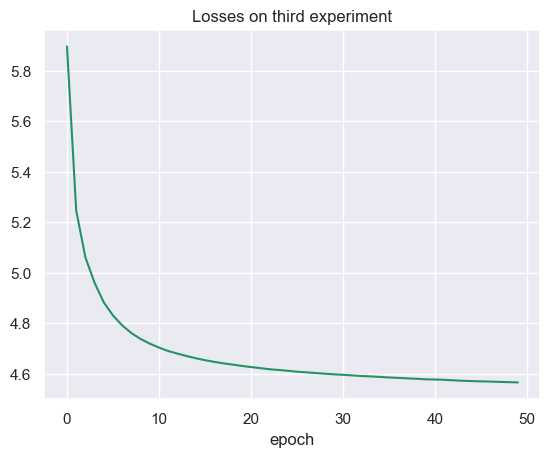

In [102]:
plt.plot(np.arange(len(experiment_losses[3])), experiment_losses[3])
plt.title('Losses on third experiment')
plt.xlabel("epoch")
plt.show()

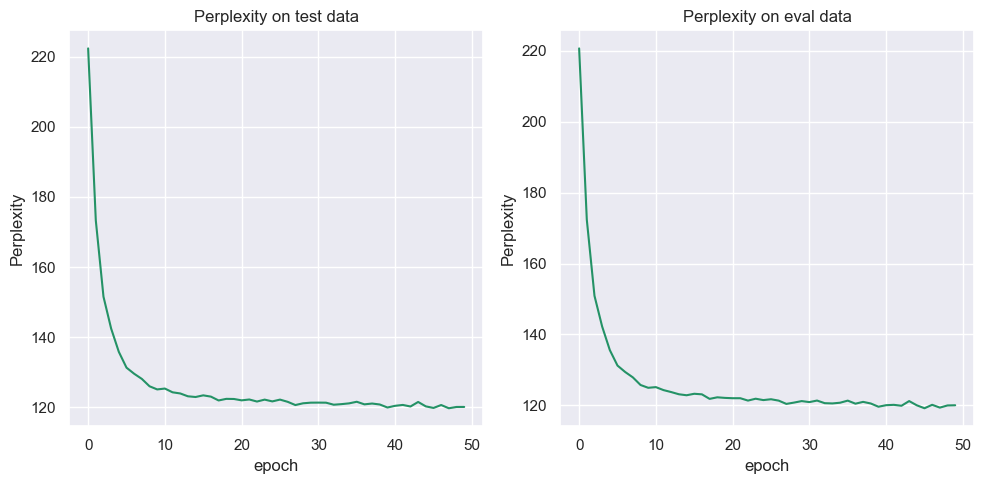

In [103]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(np.arange(len(experiment_perplexities_test[3])), experiment_perplexities_test[3])
ax2.plot(np.arange(len(experiment_perplexities_eval[3])), experiment_perplexities_eval[3])

ax1.set_title('Perplexity on test data')
ax1.set_xlabel("epoch")
ax1.set_ylabel("Perplexity")

ax2.set_title('Perplexity on eval data')
ax2.set_xlabel("epoch")
ax2.set_ylabel("Perplexity")

plt.tight_layout()
plt.show()

In [104]:
generate_sequence(model, starting_seq='he is a bad actor because')

"<bos> he is a bad actor because he 's a great actor . <eos>"

In [105]:
generate_sequence(model, starting_seq='i dont like this film because')

"<bos> i dont like this film because it 's a great movie . <eos>"

К улучшению не привело :(

### Отчет (2 балла)

Опишите проведенные эксперименты. Сравните перплексии полученных моделей. Предложите идеи по улучшению качества моделей.

In [109]:
for experiment in range(1, 4):
    print(f'Params: {experiment_params[experiment]}')
    print(f'Losses: {experiment_losses[experiment]}')
    print(f'Perplexities on test dataset: {experiment_perplexities_test[experiment]}')
    print(f'Perplexities on eval dataset: {experiment_perplexities_eval[experiment]}')
    print()


Params: ['lr = 0.01', 'weight_decay = 0.01', 'num_epoch = 15', '4 layers GRU', '1 dropout']
Losses: [7.0792557047598015, 7.033110521724389, 7.067994409537166, 6.9583531949505115, 7.0904552165817165, 7.06044735938498, 6.9429542325577644, 6.666008161148935, 5.7979125223819565, 7.353991324046873, 7.041729883577839, 6.6272541277063715, 5.763239549240976, 5.701581845793334, 7.769347568128094]
Perplexities on test dataset: [1764.4033411687342, 1148.0579864655308, 1398.9407333297347, 1464.4921003945508, 1696.9428471704225, 1277.5845818447708, 3458.4830217984454, 478.43534045962235, 362.9840074088705, 2019.871747654287, 1466.26228002807, 371.9179192164435, 331.5623716421463, 344.8384592640939, 2370.5312187156487]
Perplexities on eval dataset: [1767.7388627708856, 1148.3346965540593, 1398.3119448561165, 1465.3201137523556, 1701.8693994876728, 1277.8681775577104, 3475.923024546561, 476.1148600362653, 362.6749765980783, 2020.7117361710898, 1472.960931979232, 370.3750515271671, 331.5478024123302, 

Наилучший результат был получен на втором эксперименте. Последующее увеличение словаря и усложнение модели не привело к успеху. Скорее всего модель, полученная при втором эксперименте, оказалась самой сбалансированной. Результат считаю хорошим.

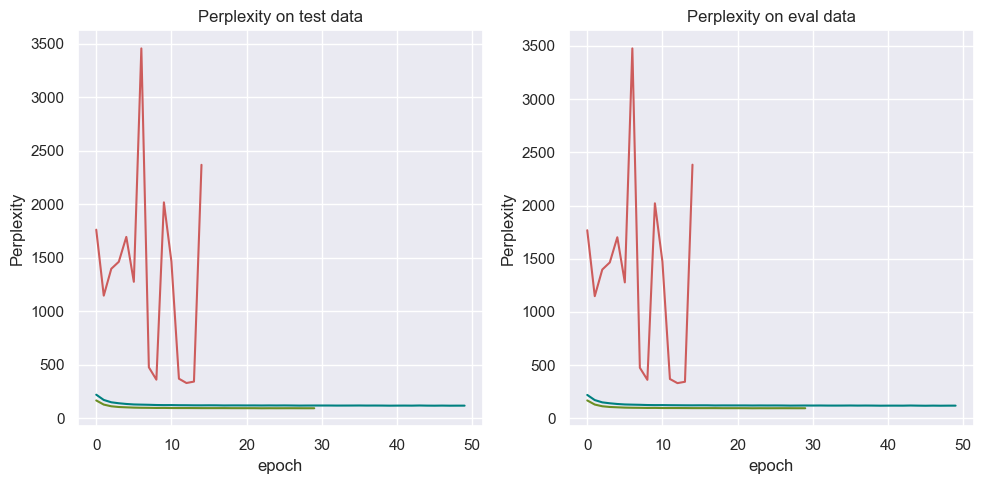

In [112]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(np.arange(len(experiment_perplexities_test[1])), experiment_perplexities_test[1], color='indianred')
ax1.plot(np.arange(len(experiment_perplexities_test[2])), experiment_perplexities_test[2], color='olivedrab')
ax1.plot(np.arange(len(experiment_perplexities_test[3])), experiment_perplexities_test[3], color='teal')

ax2.plot(np.arange(len(experiment_perplexities_eval[1])), experiment_perplexities_eval[1], color='indianred')
ax2.plot(np.arange(len(experiment_perplexities_eval[2])), experiment_perplexities_eval[2], color='olivedrab')
ax2.plot(np.arange(len(experiment_perplexities_eval[3])), experiment_perplexities_eval[3], color='teal')

ax1.set_title('Perplexity on test data')
ax1.set_xlabel("epoch")
ax1.set_ylabel("Perplexity")

ax2.set_title('Perplexity on eval data')
ax2.set_xlabel("epoch")
ax2.set_ylabel("Perplexity")

plt.tight_layout()
plt.show()

Исключим первый эксперимент

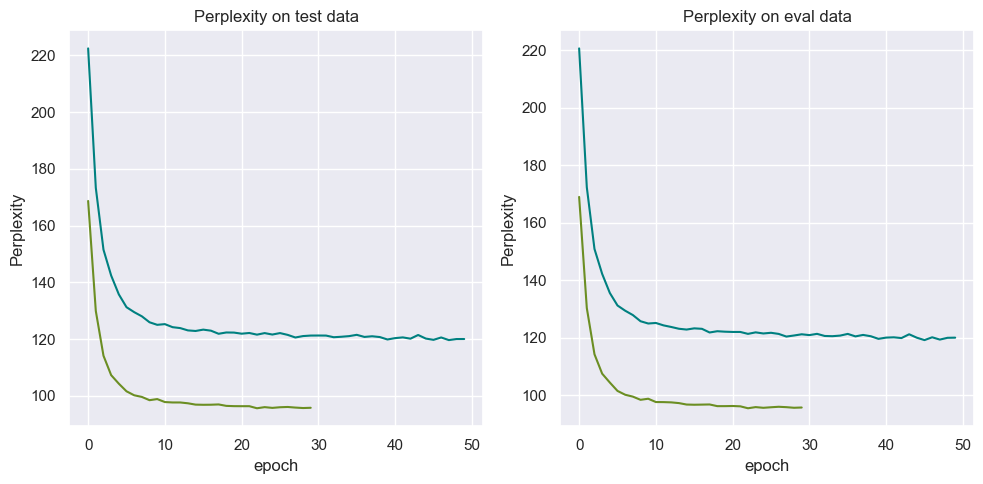

In [113]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(np.arange(len(experiment_perplexities_test[2])), experiment_perplexities_test[2], color='olivedrab')
ax1.plot(np.arange(len(experiment_perplexities_test[3])), experiment_perplexities_test[3], color='teal')

ax2.plot(np.arange(len(experiment_perplexities_eval[2])), experiment_perplexities_eval[2], color='olivedrab')
ax2.plot(np.arange(len(experiment_perplexities_eval[3])), experiment_perplexities_eval[3], color='teal')

ax1.set_title('Perplexity on test data')
ax1.set_xlabel("epoch")
ax1.set_ylabel("Perplexity")

ax2.set_title('Perplexity on eval data')
ax2.set_xlabel("epoch")
ax2.set_ylabel("Perplexity")

plt.tight_layout()
plt.show()

Идей, которые могут привести к улучшению, к сожалению, нет. Нужно пробовать разные комбинации, как оказалось накрутка всего и вся не всего приводит к хорошему результату